# **Mall Customer Segmentation Using Clustering Algorithm**

Tigas Adrian W

DS0127

An assignment of Telkom Digital Incubator 2020

## **Outline**
1. **Initialization**
>- Import the dataset
>- install libraries
2. **Exploratory Data Analysis**
>- Dataset information
>- Gender visualization
>- Analysis by count of age, annual income and spending score
>- Analysis by the correlation of each variables
3. **Data Preprocessing**
4. **KMeans Clustering**
>- Determine the optimal number of cluster (K)
>- KMeans model & visualization
5. **Conclusions**



## **Initialization**

In [2]:
# install kaggle API
!pip install kaggle

In [4]:
# upload kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tigasadrian","key":"1f5050961b6a6a1c8c1b41de39c33f75"}'}

In [5]:
# create directory for kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# import dataset from kaggle
!kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python

  0% 0.00/1.55k [00:00<?, ?B/s]
100% 1.55k/1.55k [00:00<00:00, 2.91MB/s]


In [7]:
!ls

customer-segmentation-tutorial-in-python.zip  kaggle.json  sample_data


In [8]:
# unzip the dataset folder
import zipfile
zip_ref = zipfile.ZipFile('customer-segmentation-tutorial-in-python.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [9]:
!ls

customer-segmentation-tutorial-in-python.zip  files  kaggle.json  sample_data


In [164]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

import warnings
warnings.filterwarnings('ignore')

## **Exploratory Data Analysis**


### **Dataset Information**
From the tables below we can see that:




- The dataset is based on 200 observations and consists of 5 variables:
> 1. Customer ID : The customer's identification number
>2. Gender : customer's gender
>3. Age : customer's age
>4. Annual Income (k\$) : customer's annual income (by 1000\$)
>5. Spending Score (1-100) : spending score assigned to the customer in a range of 1 - 100
- there's no missing value on the data
- the minimum **annual income** is 15 while the maximum is 137, with a mean of 60.56 and a standard deviation of 26.26
- the minimum **spending score** is 1 and the maximum is 99, with a mean of 50.20 and a standard deviation of 25.82

In [13]:
# show the dataset
df = pd.read_csv('/content/files/Mall_Customers.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [ ]:
# show the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
# check for missing value
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [ ]:
# show the descriptive statistics of the numerical attributes
# df.describe()
pd.set_option('float_format', '{:.2f}'.format)
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


### **Gender Visualization**
From the chart below, we can see that the data consist of 56% Female customers and 44% Male customer.

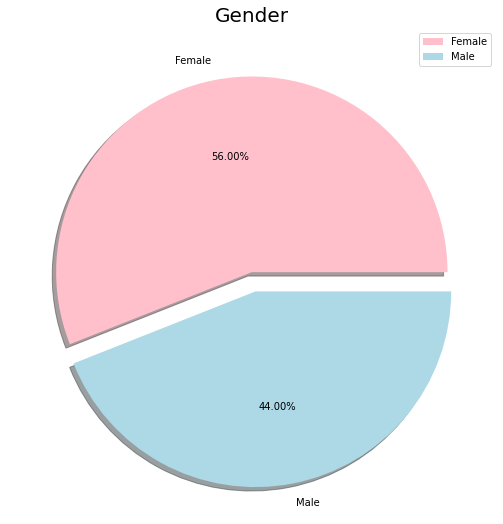

In [14]:
labels = ['Female', 'Male']
size = df['Gender'].value_counts()
colors = ['pink', 'lightblue']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Gender', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

### **Analysis by Count of Age, Annual Income and Spending Score**
From the graphs below we can see that:
- by age, the maximum population is between the late 20s and late 30s
- by the annual income, the maximum population is between 40 and 80
- by the spending score, the maximum population is between 40 and 60

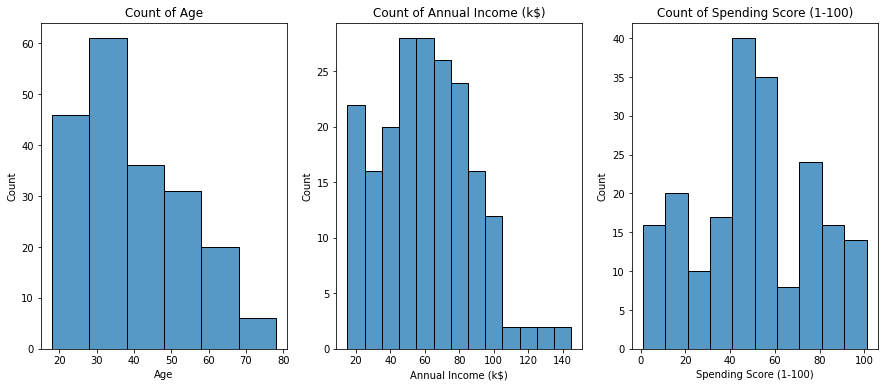

In [127]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.2)
    sns.histplot(df[x] , binwidth = 10)
    plt.title('Count of {}'.format(x))
plt.show()

### **Analysis by the correlation of each variable**
From the graphs below we can see that:
- Gender has no direct relations to the segmentation, because throughout the graphs, gender is distributed evenly
- The spending score assigned to customers over 40 years old doesn't exceed 60.
- Clustering will be effective by following the correlation between Annual Income and Spending Score since a segmented value already shown in the visualization

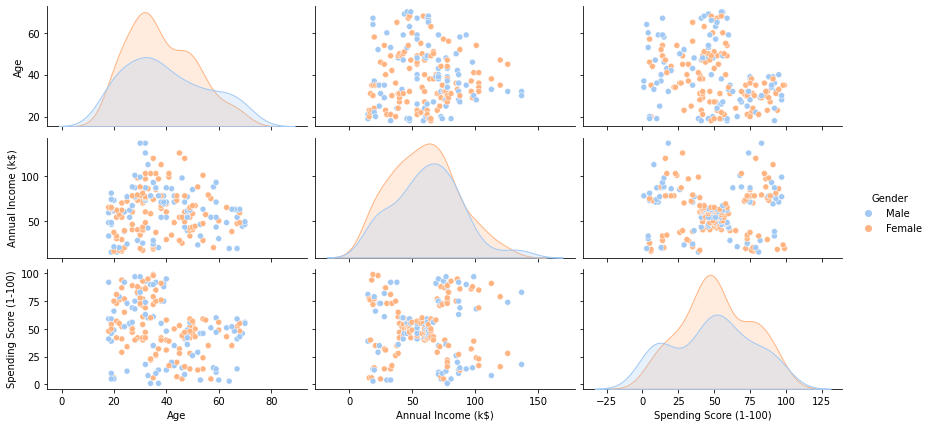

In [132]:
sns.pairplot(df.drop('CustomerID', axis=1), hue='Gender', aspect=2 , height = 2 , palette = 'pastel')
plt.show()

## **Data Preprocessing**


In [242]:
# drop unnecessary variables
df_drop = df.drop(['CustomerID', 'Gender', 'Age'], axis=1)

# apply standardization (optional, since it doesn't affect the clustering result in this particular case)

#scaler = StandardScaler() 
#column_names = df_dr.columns.tolist()
#df_drop[column_names] = scaler.fit_transform(df_dr[column_names])
#df_drop.sort_index(inplace=True)
#df_drop


X = df_drop.to_numpy()


## **KMeans Clustering**

### **Determine the optimal number of cluster (K)**

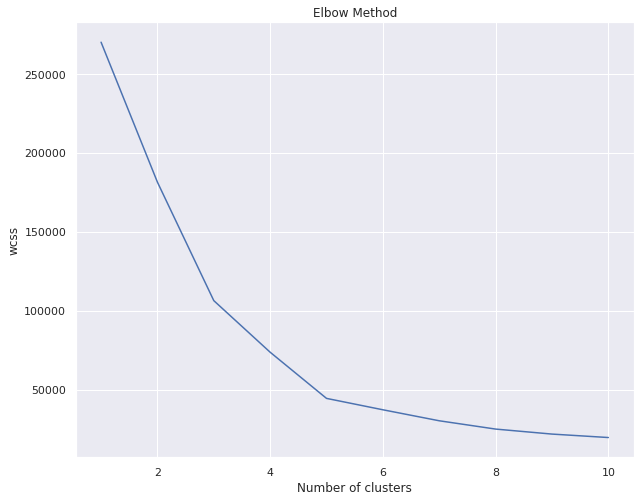

In [243]:
# Elbow method
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(1 , figsize = (10 , 8))
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [244]:
# Silhouette method
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print('For n_clusters={}, The Silhouette Coefficient is {}'.format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.39564531743995546
For n_clusters=3, The Silhouette Coefficient is 0.46761358158775435
For n_clusters=4, The Silhouette Coefficient is 0.4931963109249047
For n_clusters=5, The Silhouette Coefficient is 0.553931997444648
For n_clusters=6, The Silhouette Coefficient is 0.53976103063432
For n_clusters=7, The Silhouette Coefficient is 0.5264283703685728
For n_clusters=8, The Silhouette Coefficient is 0.4564394045323282
For n_clusters=9, The Silhouette Coefficient is 0.4565077334305076
For n_clusters=10, The Silhouette Coefficient is 0.4481683397304883


### **KMeans Model & Visualization**

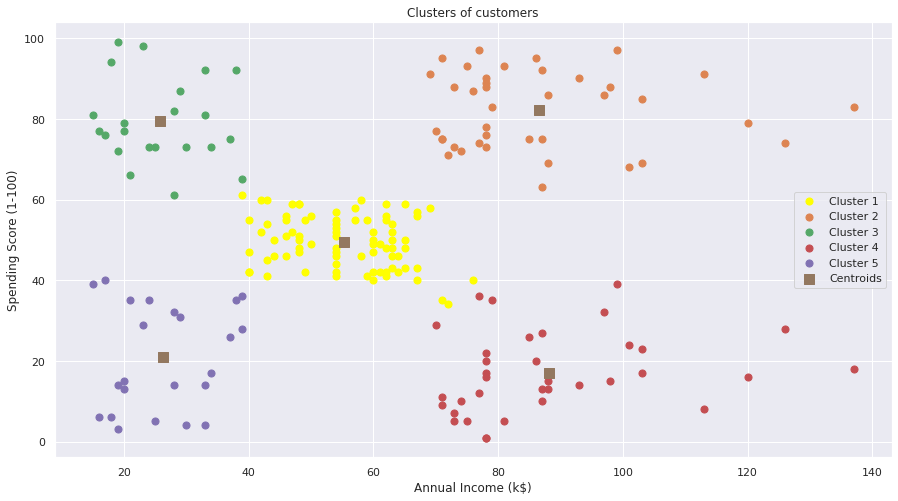

In [245]:
# Apply the K-Means Model to the Data
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=50 , algorithm = 'auto')
cluster = kmeans.fit_predict(df_drop)

# Visualising Clusters for k=5
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df_drop , palette = 'pastel')
plt.scatter(X[cluster == 0, 0], X[cluster == 0, 1], s = 50, c = 'yellow' , label = 'Cluster 1')
plt.scatter(X[cluster == 1, 0], X[cluster == 1, 1], s = 50, label = 'Cluster 2')
plt.scatter(X[cluster == 2, 0], X[cluster == 2, 1], s = 50, label = 'Cluster 3')
plt.scatter(X[cluster == 3, 0], X[cluster == 3, 1], s = 50, label = 'Cluster 4')
plt.scatter(X[cluster == 4, 0], X[cluster == 4, 1], s = 50, label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, marker = 's' , label = 'Centroids')

sns.set() 
plt.rcParams['figure.figsize'] = (15, 8)
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

## **Conclusions**
- Clusters interpretation
>1. Cluster 1 (yellow): average spending and income
>2. Cluster 2 (light brown): high spending and high income
>3. Cluster 3 (green): high spending and low income
>4. Cluster 4 (maroon): low spending and high income
>5. Cluster 5 (violet): low spending and low income
- The high spending customers are included in cluster 2 & 3
- The EDA shows that the high spending clusters (cluster 2 & 3) are the customers below 40 years old
- Customers with average annual income (40-70) have average spending score (40-60)